## Distributed System Health Prediction - EDA
```
Author: Will Kusper

Date: 1/13/2026

Goal: To understand the dataset prior to building any models or preprocessing
```

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
df = pd.read_csv('../data/distributed_system_architecture_stress_dataset.csv')

In [23]:
# Display dataset dimensions and column names
num_rows, num_cols = df.shape
print(f'The dataset contains {num_rows} rows and {num_cols} columns.')
column_names = df.columns.tolist()
print('Column names:', column_names)

print('\n')
# Print number of null values in the dataset and the records that contain them
null_values = df.isnull().sum()
print('Total null values in dataset:', null_values.sum())
null_records = df[df.isnull().any(axis=1)]
if not null_records.empty:
    print('Records with null values:')
    print(null_records)
else:
    print('No records with null values found.')

print('\n')
# Display frequency table for each categorical column
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
for col in categorical_columns:
    print(f'Frequency table for column "{col}":')
    freq_table = pd.DataFrame({ 
        'Count': df[col].value_counts(),
        'Percentage': (df[col].value_counts(normalize=True) * 100).apply(lambda x: f"{x:.2f}%")
    })
    print(freq_table)
    print('\n')

# Display summary statistics for each numerical column
numerical_columns = df.select_dtypes(include=[np.number]).columns
for col in numerical_columns:
    print(f'Summary statistics for column "{col}":')
    summary_stats = df[col].describe()
    print(summary_stats)
    print('\n')

The dataset contains 200000 rows and 21 columns.
Column names: ['architecture_type', 'deployment_type', 'communication_type', 'num_services', 'num_databases', 'requests_per_second', 'avg_payload_kb', 'read_write_ratio', 'peak_traffic_multiplier', 'cpu_utilization_percent', 'memory_utilization_percent', 'network_latency_ms', 'packet_loss_percent', 'avg_latency_ms', 'p95_latency_ms', 'error_rate_percent', 'db_connection_pool_exhausted', 'retry_storm_detected', 'circuit_breaker_open', 'system_state', 'root_cause']


Total null values in dataset: 0
No records with null values found.


Frequency table for column "architecture_type":
                   Count Percentage
architecture_type                  
hybrid             40283     20.14%
monolith           40157     20.08%
serverless         40118     20.06%
event_driven       40005     20.00%
microservices      39437     19.72%


Frequency table for column "deployment_type":
                 Count Percentage
deployment_type               

## Key Observations
```
The dataset has 200,000 rows and 21 columns

The target variable `system_state` has 4 values : "healthy", "degraded", "cascading_failure", and "total_outage"

There is a major class imbalance in the `root_cause` and `system_state` columns.
    - In `system_state`, only ~0.62% of records are either "cascading_failure" or "total_outage", meaning limited testing against those states.
    - In `root_cause`, only ~1.30% of records have a root cause other than "none"

No missing values present in the dataset
```

## Distribution of System States

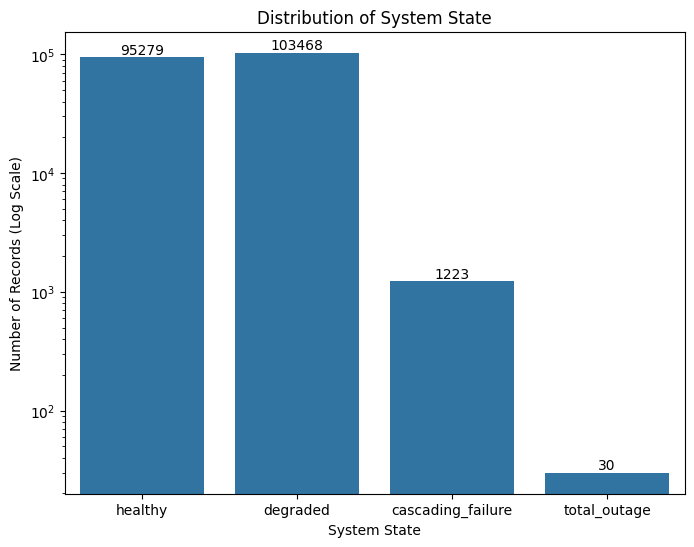

In [ ]:

# Visualize distribution of 'system_state' variable
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x='system_state')
plt.title('Distribution of System State')
plt.xlabel('System State')
plt.ylabel('Number of Records (Log Scale)')
plt.yscale('log')  # Using a logarithmic scale for better visibility of the two smaller classes

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom')

plt.show()

plt.savefig('../results/figures/system_state_distribution.png')

### What this shows :

This visualization the distribution of the `system_state` feature on a logarithmic scale, highlighting a massive class imbalance. The vast majority of records are labeled as `healthy` or `degraded`, while `cascading_failure` and `total_outage` occur very rarely in comparison.

By using the logarithmic y-axis, it is very obvious that the frequency of catastrophic system states are orders of magnitude lower than those of systems that are merely degraded. This aligns with real-world system performance, where redundancy and safeguards are put in place to prevent failures or total outages.

For classification, this imbalance poses a massive challenge. Without mitigation, a classifier may be biased towards the two dominant classes and perform poorly on the rarer failure states. Addressing this imbalance will be critical for reliable prediction on system states.  

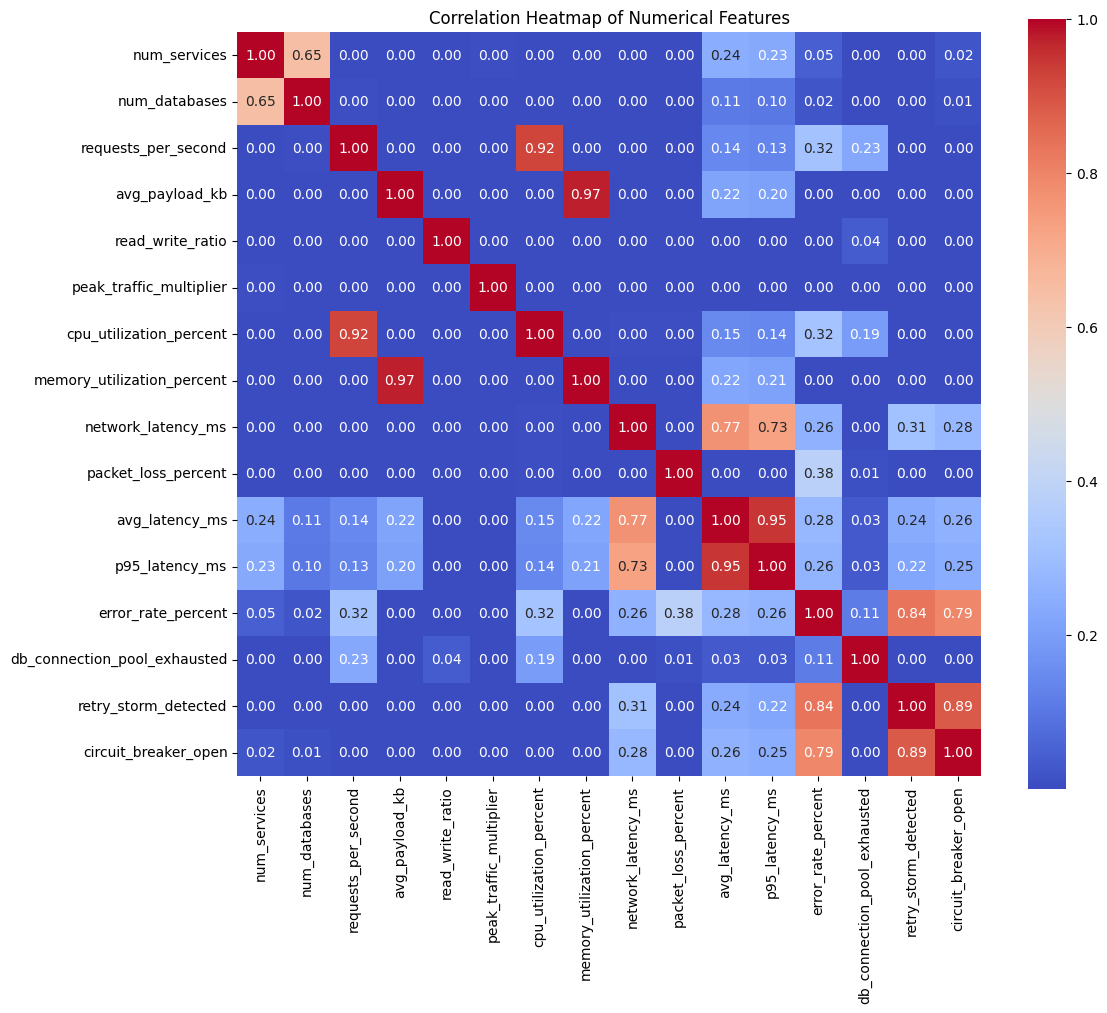

In [ ]:
# Visualize the correlation heatmap for numerical features
plt.figure(figsize=(12, 10))
corr_matrix = df[numerical_columns].corr()
correlation_matrix = corr_matrix.abs()
plt.title('Correlation Heatmap of Numerical Features')
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.show()
annotations = correlation_matrix.stack().reset_index()
annotations.columns = ['Feature 1', 'Feature 2', 'Correlation']

plt.savefig('../results/figures/corr_heatmap.png')

## What this shows :
This heatmap displays the pairwise Pearson correlations between the numerical system metrics, which highlights some relationships and potential redundancy within the features. Certain strong correlations appear which make logical sense, such as `requests_per_second` and `cpu_utilization_percent`, `avg_payload_kb` and `memory_utilization_percent`, `error_rate_percent` and `retry_storm_detected`/`circuit_breaker_open`

Most of the other features have zero or near-zero correlation, suggesting that many metrics can capture distinct system behaviors, or that any multicollinearity is localized rather than widespread in the dataset. 

Overall, this heatmap helps identify some redundant features that may be pruned, the most meaningful system metric relationships, and failure-related metrics that will be useful for system health prediction.

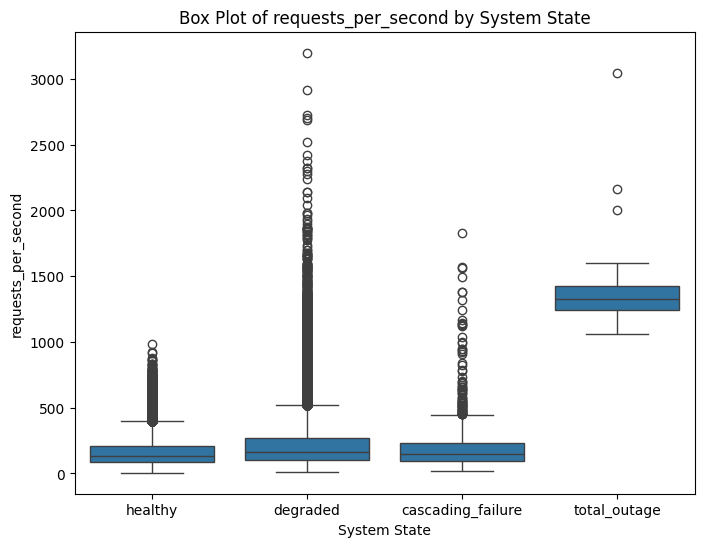

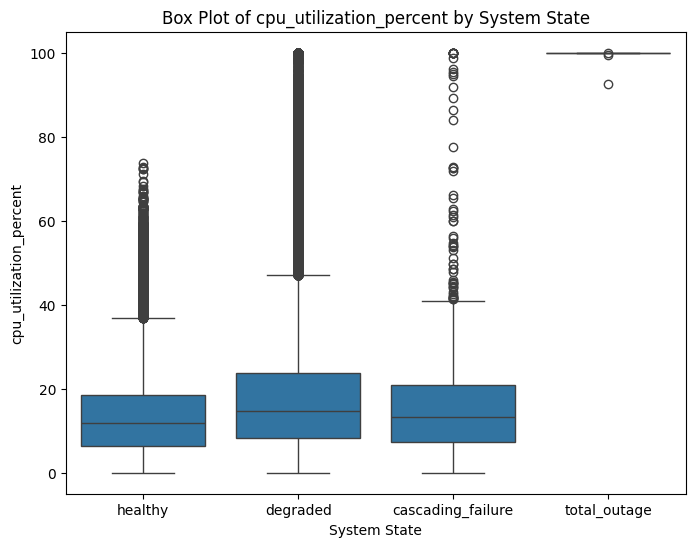

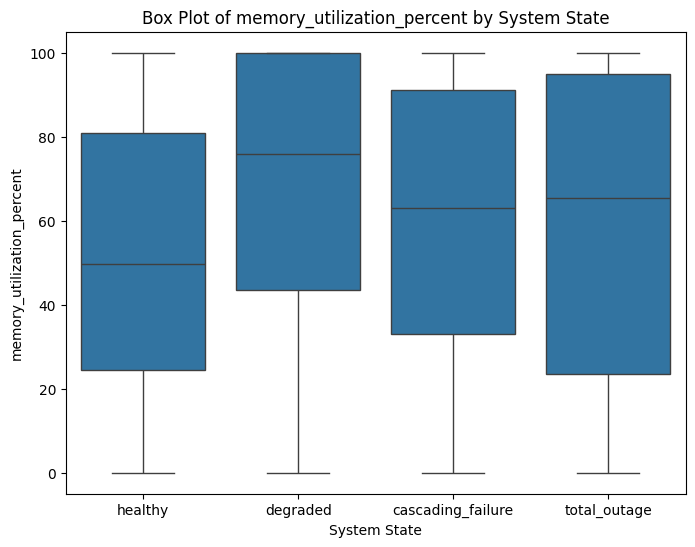

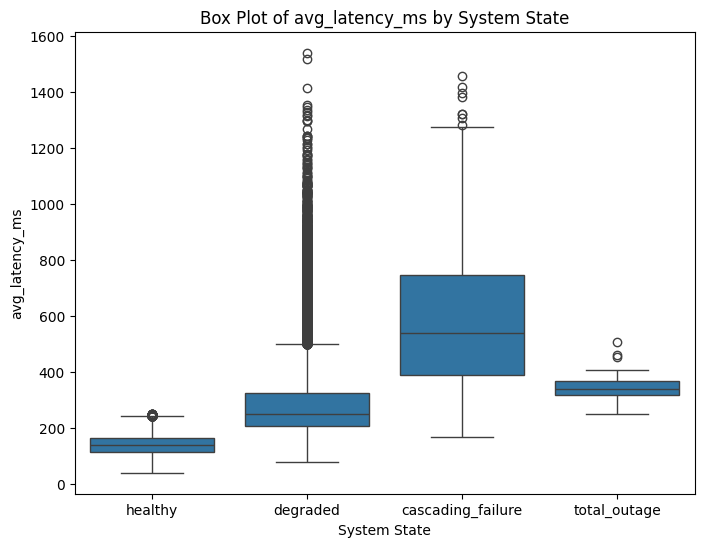

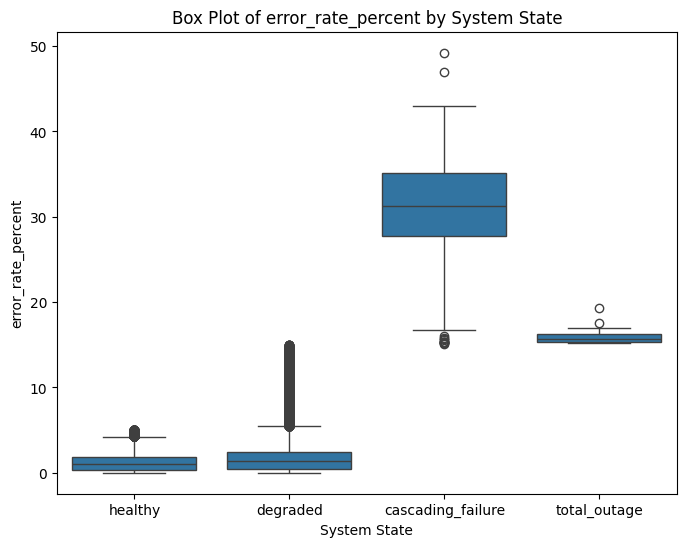

In [ ]:
# Visualize box plots for key numerical features grouped by 'system_state'
# Selecting features that show system performance, resource usage, latency, and error rates
key_features = numerical_columns[[2, 6, 7, 10, 12]] # Selecting specific columns by index
for feature in key_features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df, x='system_state', y=feature)
    plt.title(f'Box Plot of {feature} by System State')
    plt.xlabel('System State')
    plt.ylabel(feature)
    plt.show()
    plt.savefig(f'../results/figures/boxplot_{feature}_by_system_state.png')

## What this shows : 

These boxplots show the distributions of request frequency, resource utilization, latency, and reliability across different server states. These distributions are key for understanding what happens to cause system degradation, or what happens as system health degrades. In addition, these features may be good indicators of a system's health.

### requests_per_second
This boxplot shows how the numbers of requests per second are distributed in each system state. For example, it takes a minimum of 1,000 requests per second in order to reach a state of `total_outage`. However, many systems that are merely `degraded` will experience more requests than those that are in `total_outage` or `cascading_failure`. This suggests that architectural resilience varies significantly. While some systems may gracefully degrade under load, others may fail catastrophically. This indicates there may be design flaws in processes such as load balancing or circuit breakers.

### cpu_utilization_percent
Healthy servers clearly are able to process requests efficiently, while degraded or failing servers will use more CPU to fight against issues like excessive retries, database issues, or inefficient processes. Total outages maxing out CPU usage suggests that the system may have no way to gracefully degrade.

High CPU usage is a great indicator for unhealthy systems, as no record for `healthy` systems reaches even 80% usage. While there are many outliers that may mislead a model, maxed out CPU usage may be a good predictor for a `total_outage`.

### memory_utilization_percent
Memory usage appears similar across all system states, but some valuable behaviors can be seen. Healthy systems are able to efficiently process requests, and thus they are queued and held in memory for less time. This would explain the lower average usage of memory for healthy systems. Degraded or failing systems may accumulate more requests, which would consume more memory. 

While this plot is beneficial for human understanding, a model may find it difficult to use this feature for prediction. Due to all four system states sharing the same range of values, there is no clear way to use this to predict the state of the system.

### avg_latency_ms
This box plot mostly makes logical sense. A `healthy` server is able to respond quickly to requests. Systems that are merely `degraded` will be able to respond to requests relatively quickly, however it may take longer due as it takes longer to respond to the given requests. `cascading_failure` shows the highest latency because the system is still able to process requests, but is struggling as failures delay processing. What may be counterintuitive is the relatively low latency during a `total_outage`. This gives an illusion of fast responses, but may simply mean that requests are being dropped or immediately rejected. From a machine learning standpoint, the lowest latency values would be great predictors for healthy systems, while the highest are strong predictors for either `degraded` or `cascading_failure` states.

### error_rate_percent
Error rates escalate as the system degrades. Interestingly, in a `total_outage`, it seems as if the error rate drops. This would make sense in a case where requests are dropped or rejected, as it would reject them prior to logging or returning an error. This masks the true severity of the system health. This makes high error rates a very strong predictor for the `cascading_failure` state.